<a href="https://colab.research.google.com/github/PauDK/Deceptive-Review-Detection/blob/main/BERT_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-text
!pip install tf-models-official

**Importing** **Libraries**


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from pprint import pprint

In [ ]:
print(tf.__version__)

2.10.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Importing Dataset and Feature Class and Target Class

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/deceptiveopinion/preprocess.csv", index_col=0)
X = df['Ori_Review']
y = df['label']

In [ ]:
df.head()

,rating,label,Ori_Review
category,,,
Home_and_Kitchen_5,5,1,"Love this! Well made, sturdy, and very comfor..."
Home_and_Kitchen_5,5,1,"love it, a great upgrade from the original. I..."
Home_and_Kitchen_5,5,1,This pillow saved my back. I love the look and...
Home_and_Kitchen_5,1,1,"Missing information on how to use it, but it i..."
Home_and_Kitchen_5,5,1,Very nice set. Good quality. We have had the s...


**Splitting the Data for Training and Testing**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Loading BERT pre-processing model to pre-process the review text** 

In [ ]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
preprocessor.tokenize

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7ff74d505f50>

In [ ]:
text_inputs = [keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

seq_length = 512  # Set sequence length
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))

preprocessed_text = bert_pack_inputs(tokenized_inputs)

In [ ]:
preprocessed_text

{'input_word_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_type_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_mask': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>}

In [ ]:
k=tokenize(X_train[1:8])

In [ ]:

k[0].shape

TensorShape([34, None])

In [ ]:
sizes = []
tokens = tokenize(X_train)
for i in range(tokens.shape[0]):
  sizes.append(tokens[i].shape[0])

from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.hist(sizes)
ax2.boxplot(sizes)

In [ ]:
sizes

In [ ]:
text_inputs

[<KerasTensor: shape=(None,) dtype=string (created by layer 'input_1')>]

In [ ]:
preprocessed_text

{'input_word_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_type_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_mask': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>}

**Loading the BERT pre-trained model which provides dense vector representations for natural language by using a deep, pre-trained neural network.**

In [ ]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [ ]:
# Train all BERT layers as suggested by BERT developers
bert_encoder.trainable = True

# Bert layers
outputs = bert_encoder(preprocessed_text)

# Dense layers
l = keras.layers.Dense(1, activation='sigmoid', name="output") (outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = keras.Model(inputs=text_inputs, outputs = [l])

In [ ]:
model.input_shape

(None,)

In [ ]:
epochs = 2
batch_size = 8
init_lr = 3e-5  # best of [5e-5, 3e-5, 2e-5]

train_data_size = X_train.shape[0]
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

test_data_size = X_test.shape[0]

In [ ]:
optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics='accuracy')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['keras_layer[0][0]']            
                                e, 512),                                                          
                                 'input_word_ids':                                                
                                (None, 512),                                                

**Training the Model**

In [ ]:
bert_encoder.trainable = False
model.fit(X_train,
          y_train,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=(X_test, y_test))

Epoch 1/2
4043/4043 [==============================] - 4762s 1s/step - loss: 0.1501 - accuracy: 0.9517 - val_loss: 0.2916 - val_accuracy: 0.9451
Epoch 2/2
3145/4043 [======================>.......] - ETA: 16:17 - loss: 0.0357 - accuracy: 0.9923

4043/4043 [==============================] - 3774s 933ms/step - loss: 0.0357 - accuracy: 0.9923 - val_loss: 0.2057 - val_accuracy: 0.9622


In [ ]:
prediction = model.predict(X_test)
prediction_real = model.predict(X_test[y_test == 0])
prediction_fake = model.predict(X_test[y_test == 1])

127/127 [==============================] - 174s 1s/step


In [ ]:
prediction_bi_real = prediction_real.copy()
prediction_bi_real[np.where(prediction_real <= 0.5)] = 0
prediction_bi_real[np.where(prediction_real > 0.5)] = 1
print('True Positive Rate:', '{:.2%}'.format(1 - sum(prediction_bi_real)[0] / len(prediction_bi_real)))

prediction_bi_fake = prediction_fake.copy()
prediction_bi_fake[np.where(prediction_fake <= 0.5)] = 0
prediction_bi_fake[np.where(prediction_fake > 0.5)] = 1
print('True Negative Rate:', '{:.2%}'.format(sum(prediction_bi_fake)[0] / len(prediction_bi_fake)))

True Positive Rate: 96.52%
True Negative Rate: 99.57%


In [ ]:
demo_ind = np.random.choice(len(X_test.index))
realfake = 'Real' if y_test[demo_ind] == 0 else 'Fake'
prediction = model.predict([X_test[demo_ind]])
prediction_rf = 'Real' if prediction <= 0.5 else 'Fake'

print(f'{realfake} review to be fed to model:\n', X_test[demo_ind], '\n')
print(f'Model prediction: {prediction_rf}')

1/1 [==============================] - 0s 41ms/step
Fake review to be fed to model:
 Tank looked wonderful. A bit small for the price, but I will admit that it's been a 

Model prediction: Fake


**Saving the trained model**

In [ ]:
import os

main_save_path = '/content/drive/MyDrive/deceptiveopinion'
saved_model_name = 'Fine_Tune_Bert'
saved_model_path = os.path.join(main_save_path, "model-966-")
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save(saved_model_path, options=save_options,include_optimizer=False,)

**Reloading the saved model for testing purposes**

In [ ]:
reloaded_model = tf.saved_model.load("/content/drive/MyDrive/deceptiveopinion/model-96-")

In [ ]:
X_test.shape

(8087,)

In [ ]:
X_test[y_test == 0].shape

(4040,)

In [ ]:
prediction_real = reloaded_model(X_test[y_test == 0][:230])
prediction_fake = reloaded_model(X_test[y_test == 1][:230])

In [ ]:
prediction_fake=prediction_fake.numpy()
prediction_real=prediction_real.numpy()

In [ ]:
prediction_real

array([[2.55248069e-05],
       [1.02000358e-03],
       [1.08769680e-04],
       [1.12858806e-05],
       [9.95835900e-01],
       [1.51000304e-05],
       [6.76383497e-05],
       [4.07600201e-05],
       [9.93665874e-01],
       [3.53583717e-03],
       [1.41543160e-05],
       [5.73840880e-05],
       [3.24083114e-04],
       [2.78701889e-04],
       [4.83463169e-04],
       [8.13059160e-05],
       [2.79956439e-05],
       [9.42460465e-05],
       [1.37510488e-05],
       [2.33640578e-02],
       [1.17736008e-05],
       [4.23503952e-05],
       [6.86599305e-05],
       [1.96349970e-03],
       [1.65601610e-04],
       [1.22145448e-05],
       [2.05208324e-02],
       [7.73736901e-05],
       [1.43172956e-05],
       [1.44471842e-05],
       [1.48937152e-05],
       [2.40525533e-05],
       [1.73656590e-05],
       [1.62786237e-05],
       [1.29907039e-05],
       [3.62833118e-04],
       [1.53624260e-05],
       [9.89628792e-01],
       [2.27704571e-04],
       [8.65372713e-05],


In [ ]:
prediction_fake

array([[0.99999595],
       [0.99999607],
       [0.99999654],
       [0.99999654],
       [0.9999943 ],
       [0.9999945 ],
       [0.9999949 ],
       [0.99999535],
       [0.99999547],
       [0.9999957 ],
       [0.9999956 ],
       [0.9999956 ],
       [0.9999944 ],
       [0.9999962 ],
       [0.9999938 ],
       [0.9999957 ],
       [0.99999475],
       [0.999995  ],
       [0.99999344],
       [0.99999607],
       [0.99999404],
       [0.9999938 ],
       [0.9999958 ],
       [0.99999547],
       [0.9999968 ],
       [0.9999951 ],
       [0.9999962 ],
       [0.99999475],
       [0.9999949 ],
       [0.999995  ],
       [0.9999964 ],
       [0.99999523],
       [0.9999957 ],
       [0.99999654],
       [0.99999523],
       [0.9999951 ],
       [0.99999535],
       [0.99999595],
       [0.9999944 ],
       [0.9999957 ],
       [0.99996364],
       [0.9999958 ],
       [0.9999949 ],
       [0.99999654],
       [0.99999547],
       [0.9999956 ],
       [0.99999475],
       [0.999

In [ ]:
prediction_bi_real = prediction_real.copy()
prediction_bi_real[np.where(prediction_real <= 0.5)] = 0
prediction_bi_real[np.where(prediction_real > 0.5)] = 1
print('True Positive Rate:', '{:.2%}'.format(1 - sum(prediction_bi_real)[0] / len(prediction_bi_real)))

prediction_bi_fake = prediction_fake.copy()
prediction_bi_fake[np.where(prediction_fake <= 0.5)] = 0
prediction_bi_fake[np.where(prediction_fake > 0.5)] = 1
print('True Positive Rate:', '{:.2%}'.format(sum(prediction_bi_fake)[0] / len(prediction_bi_fake)))

True Positive Rate: 96.52%
True Positive Rate: 99.57%


In [ ]:
y_pred=np.concatenate( (prediction_real,prediction_fake))

In [ ]:
y_pred[[np.where(y_pred <= 0.5)]]=0
y_pred[[np.where(y_pred >= 0.5)]]=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [ ]:
y_true=np.concatenate( (y_test[y_test==0][:230],y_test[y_test==1][:230]))

**Evaluation of test results from the saved model**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       230
           1       0.96      1.00      0.98       230

    accuracy                           0.98       460
   macro avg       0.98      0.98      0.98       460
weighted avg       0.98      0.98      0.98       460



In [ ]:
print(confusion_matrix(y_true,y_pred))

[[221   9]
 [  1 229]]


In [ ]:
import seaborn as sns

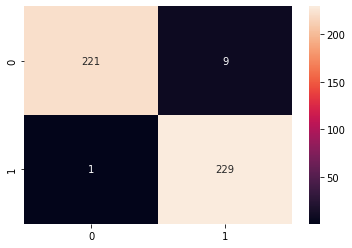

In [ ]:
sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt="g")

**Testing with random records from test data**

In [ ]:
demo_ind = np.random.choice(len(X_test.index))
realfake = 'Real' if y_test[demo_ind] == 0 else 'Fake'
prediction = reloaded_model([X_test[demo_ind]])
prediction_rf = 'Real' if prediction.numpy()[0] <= 0.5 else 'Fake'

print(f'{realfake} review to be fed to model:\n', X_test[demo_ind], '\n')
print(f'Model prediction: {prediction_rf}')

Fake review to be fed to model:
 Easily paired with my SmartThings hub. The only problem is that it's only a couple of hours. I had to replace the bulb with the new one, so it's not that big a deal. 

Model prediction: Fake
